# Dot plot for power system  data

This is an exloration of the visual power of Cleveland dot plot
to show power system data. Data is for the French power system (RTE éCO₂mix).

As an example of simple dot plot, we plot, for each plant category, the cumulated generation over a given year.

Dot plots get even more interesting with *multiway* dot plots, where multiple data are superimposed.
Here we plot, for each plant category:
* power capacity (GW)
* average power (GW)

and we can even add some quantiles

The average power data is an equivalent information to the more commonly quoted
total yearly energy in TWh (factor 24×365/1000).
The benefit of using the average power is that it can be superimposed
on the plot with the power capacity since it has the same unit.
The ratio of the two is the *capacity factor* of the plant category.

Notice: we will approximate the power capacity with the maximum
value over the year (hourly data).

*The case for dot plot:*

Showing yearly energy production of each category is commonly done
with **pie charts**, such as in RTE's [Bilan électrique 2018/Production totale](https://bilan-electrique-2018.rte-france.com/production-totale/#):

![pie chart for the energy share of each plant type in 2018](img/RTE_2018_energy_pie-chart.png)

However, William S. Cleveland in his book [The Elements of Graphing Data](https://www.goodreads.com/book/show/18619.Elements_of_Graphing_Data) is advocating for a vizualiazation technique he find more powerful: the **dot plot**.
There are some scientific experiments
([Cleveland and McGill, 1984](https://www.jstor.org/stable/2288400))
backing this claim,
in particular about the ability of **efficiently read** single point values from the graph
and also **compare** different point together.
Also, he advocates the use of *log₂* scale for values which have different order of magnitudes,
but not enough to make the best use of the more common *log₁₀* scale.
One unit of difference corresponds to a factor 2.

The power system data display on the dot plot with the *log₂* scale
enables interesting comparisons:

* for each type of production, the distance between the average and the max is
  the capacity factor (one unit: 50%, two units: 25% like for the wind)
* comparison between all production types, both in capacity and in average power
* when superimposing several years, comparison across time;

All this comparison would be more difficult with a pie chart.
A pie chart is better at showing shares of the total.
However, the trick is to also show the total load, so that the difference in log scale
with a given production type is an image of its share.

Pierre Haessig, October 2019


Some other blog article on dot plots:

* “Cleveland (Dot Plot) Rocks! (with Tableau)”
https://spencerbaucke.com/2019/09/12/cleveland-dot-plot-rocks/
* UC Business Analytics R Programming Guide, “Cleveland Dot Plots” page
http://uc-r.github.io/cleveland-dot-plots

In [1]:
import numpy as np
from numpy import log2, nan

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
%matplotlib inline

Help on how to read a log₂ scale:
relation between the difference of two log values and the ratio of the actual values

In [2]:
x_list = np.array([0.5, 1, 1.5, 2, 3, 4, 5])

# ratios
r_list = 2**(x_list)

scale_help = pd.DataFrame({
    'Δlog': x_list,
    'ratio a/b (%)':100/r_list,
    'ratio b/a':r_list,
})
scale_help.set_index('Δlog', inplace=True)
scale_help.round(1).transpose()

Δlog,0.5,1.0,1.5,2.0,3.0,4.0,5.0
ratio a/b (%),70.7,50.0,35.4,25.0,12.5,6.2,3.1
ratio b/a,1.4,2.0,2.8,4.0,8.0,16.0,32.0


## For one single year

Read eCO2mix data (adapted from [RTE_explore_concat.ipynb](RTE_explore_concat.ipynb) Notebook)

In [3]:
columns_FR = [
    'Consommation',
    'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
    'Eolien', 'Solaire',
    'Hydraulique', 'Pompage', 'Bioénergies',
    'Ech. physiques',
]

Translation of column names

In [4]:
columns = [
    'Load',
    'Oil', 'Coal', 'Gas', 'Nuclear',
    'Wind', 'Solar',
    'Hydro', 'Pump', 'Bio',
    'Exchanges',
]

In [5]:
def read_eCO2mix(fname, columns):
    """read eCO2mix data file. keep only `columns`"""
    df = pd.read_csv(fname, compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})
    # keep only data at 30 min step
    df = df.iloc[::2,:]
    # set date as the index
    df.set_index('date', verify_integrity=True, inplace=True)
    df.index.name = ''
    # select columns
    return df.loc[:, columns]

### Read year 2018 as an example

Read only the main columns (not the detailed ones)

In [6]:
df = read_eCO2mix('data/eCO2mix_RTE_Annuel-Definitif_2018.xls.xz', columns_FR)
# translate names:
df = df.rename(dict(zip(columns_FR, columns)), axis=1)

df.tail(3)

,Load,Oil,Coal,Gas,Nuclear,Wind,Solar,Hydro,Pump,Bio,Exchanges
,,,,,,,,,,,
2018-12-31 22:30:00,60939.0,146.0,11.0,3886.0,55186.0,1569.0,-2.0,4451.0,-2815.0,1165.0,-2660.0
2018-12-31 23:00:00,63977.0,146.0,11.0,3910.0,55589.0,1537.0,-2.0,5148.0,-1364.0,1172.0,-2171.0
2018-12-31 23:30:00,63803.0,146.0,12.0,3452.0,55404.0,1543.0,-2.0,4688.0,-1474.0,1166.0,-1133.0


### Pre-processing RTE data

The problem lies with negative values:
* **Pump** is always negative
* **Exchanges** is negative and positive

In [7]:
df.Pump.min(), df.Pump.max()

(-3651.0, -4.0)

In [8]:
df.Exchanges.min(), df.Exchanges.max()

(-16577.0, 9574.0)

#### Splitting exchanges

For physical exchanges: split into two positive variables: Import and Export

In [9]:
pos = lambda x:  x if x >= 0 else 0
neg = lambda x: -x if x  < 0 else 0

In [10]:
df['Import'] = df['Exchanges'].map(pos)
df['Export'] = df['Exchanges'].map(neg)

In [11]:
del df['Exchanges']

#### Flipping pumped hydro power

For pumped hydro: flip the sign

In [12]:
df.Pump *= -1

#### Residual negative values

negative values are probably the self-consumption of Coal and Solar

In [13]:
(df < 0).sum()

Load          0
Oil           0
Coal       1544
Gas           0
Nuclear       0
Wind          0
Solar      7885
Hydro         0
Pump          0
Bio           0
Import        0
Export        0
dtype: int64

In [14]:
df.Solar.describe()

count    17520.000000
mean      1208.082477
std       1739.025942
min         -2.000000
25%         -1.000000
50%         24.000000
75%       2153.250000
max       6430.000000
Name: Solar, dtype: float64

In [15]:
df.Coal.describe()

count    17520.000000
mean       656.297146
std        607.614666
min        -60.000000
25%         16.000000
50%        546.000000
75%       1052.000000
max       2931.000000
Name: Coal, dtype: float64

#### Conversion MW → GW

In [16]:
df /= 1000

### Statistical Aggregation

#### Average and Max
* mean power
* max power (i.e. a proxy for the capacity)

In [17]:
stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})

#### Sorting for dot plots

since there are two stats we want to display, a choice must be made:

* sorting by max (≈ power capacity)
* sorting by mean (∝ yearly energy production)

In [18]:
stats.sort_values('avg', inplace=True)
stats

,avg,max
Import,0.109121,9.574
Oil,0.234531,2.507
Coal,0.656297,2.931
Pump,0.844762,3.651
Bio,1.089724,1.286
Solar,1.208082,6.430
Wind,3.211288,12.287
Gas,3.446567,9.700
Export,7.383905,16.577
Hydro,7.695196,17.434


#### Total generation over the year (in TWh)

Remark: this is equal to average × duration of the year

for some reason, figures are slightly different than [RTE's 2018 production data](https://bilan-electrique-2018.rte-france.com/production-totale/#). Some examples:

* Nuclear: 393.2 TWh
* Gas: 31.4 TWh
* Wind : 27.8 TWh
* Solar 10.2 TWh
* ... and Load 478 TWh

In [19]:
stats['int'] = df.sum()/(2*1000)
stats['int'].round(1)

Import       1.0
Oil          2.1
Coal         5.7
Pump         7.4
Bio          9.5
Solar       10.6
Wind        28.1
Gas         30.2
Export      64.7
Hydro       67.4
Nuclear    393.0
Load       475.5
Name: int, dtype: float64

#### Off times

Some plants spend a significant fraction of the year with *close to zero production*.
This is visible on a cumulated histogram of normalized power

In [20]:
df_norm = df / df.max() # production scaled to the max.

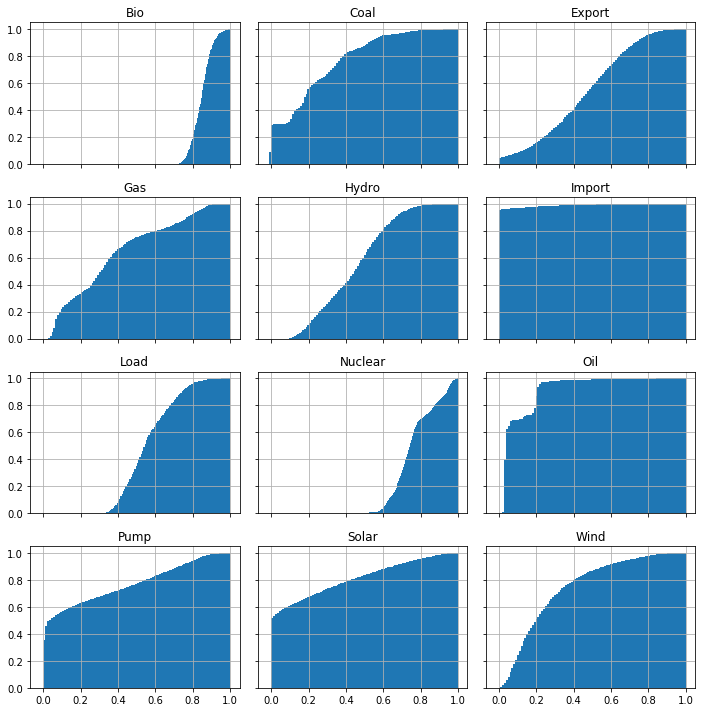

In [21]:
df_norm.hist(cumulative=True, density=True, bins=100,
        figsize=(10,10), sharex=True, sharey=True)
plt.tight_layout()

Average off time:

apart for wind, the off time is significant

In [22]:
df_zero = df_norm<0.01
stat_off = df_zero.mean()
stat_off[stat_off > 0]

Oil       0.000057
Coal      0.293265
Wind      0.000742
Solar     0.519692
Pump      0.350342
Import    0.956849
Export    0.047432
dtype: float64

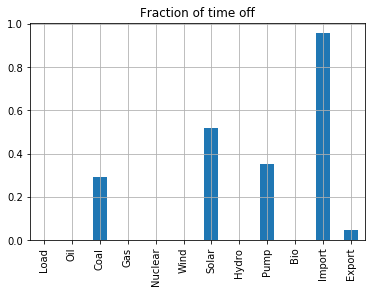

In [25]:
stat_off.plot.bar()
plt.grid()
plt.title('Fraction of time off');

Appending the off time statistic

In [26]:
stats['off'] = stat_off
stats.head(3)

,avg,max,int,off
Import,0.109121,9.574,0.955899,0.956849
Oil,0.234531,2.507,2.054493,0.000057
Coal,0.656297,2.931,5.749163,0.293265


#### Quantiles for non zero values

comparing with and without removal of zero values

In [27]:
df_norm.quantile(0.1)

Load       0.408549
Oil        0.031113
Coal       0.000341
Gas        0.065876
Nuclear    0.629739
Wind       0.062017
Solar     -0.000156
Hydro      0.201784
Pump       0.002465
Bio        0.779938
Import     0.000000
Export     0.128365
Name: 0.1, dtype: float64

In [28]:
df_norm[~df_zero].quantile(0.1)

Load       0.408549
Oil        0.031113
Coal       0.120096
Gas        0.065876
Nuclear    0.629739
Wind       0.062228
Solar      0.051540
Hydro      0.201784
Pump       0.016708
Bio        0.779938
Import     0.042511
Export     0.185015
Name: 0.1, dtype: float64

In [29]:
q_list = [0.05, 0.25, 0.75, 0.95]
stats_q = df[~df_zero].quantile(q_list)
stats_q

,Load,Oil,Coal,Gas,Nuclear,Wind,Solar,Hydro,Pump,Bio,Import,Export
0.05,36.98195,0.073,0.319,0.52300,35.73270,0.5443,0.1740,2.89700,0.050,0.982,0.25925,1.9774
0.25,44.92975,0.084,0.518,1.18800,40.44075,1.3380,0.9720,5.18775,0.181,1.042,0.88825,5.2600
0.75,63.06900,0.476,1.184,4.85400,49.87925,4.3830,3.8745,9.90925,2.261,1.132,3.78700,10.3290
0.95,75.99780,0.557,1.952,8.10805,56.46905,8.7170,5.6093,12.66715,3.089,1.202,6.22575,13.2220


Appending to the main `stat` DataFrame

In [30]:
for q in stats_q.index:
    q_name = f'q{100*q:02.0f}' # ex: 'q25'
    stats[q_name] = stats_q.loc[q]

stats.head(3)

,avg,max,int,off,q05,q25,q75,q95
Import,0.109121,9.574,0.955899,0.956849,0.25925,0.88825,3.787,6.22575
Oil,0.234531,2.507,2.054493,0.000057,0.07300,0.08400,0.476,0.55700
Coal,0.656297,2.931,5.749163,0.293265,0.31900,0.51800,1.184,1.95200


### Dot plot for a single period

Tweak the Matplotlib plotting font:

In [31]:
#font_sans_default = plt.rcParams['font.sans-serif']
plt.rcParams['font.sans-serif'] = ['Lato']
# Fixes weights to 'medium' rather than 'normal' due to bug with Matplotlib 3.1.1
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['axes.labelweight'] = 'medium'
plt.rcParams['axes.titleweight'] = 'medium'
plt.rcParams['figure.titleweight'] = 'medium'

#### Simple dot plot of energy

Only one data: generation of each type

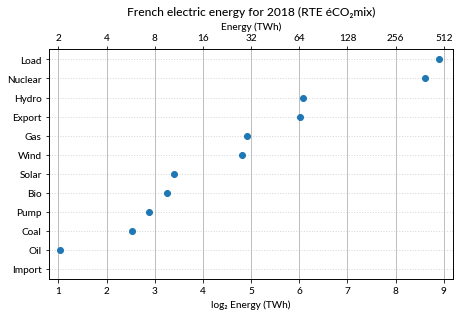

In [32]:
col = 'int'
period = 2018

fig, ax = plt.subplots(1,1, figsize=(6.5,4.5))

# twin ax with shared scale
# cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
ax2 = ax.twiny()
ax.get_shared_x_axes().join(ax, ax2)

ax.plot(log2(stats[col]), stats.index,
        ls='', marker='o', color='tab:blue')

ax.grid(axis='x', ls='-')
ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
ax.set_axisbelow(True) # grid below data points

ax.set(
    #xlabel = 'log₂ Power (GW)',
    xlabel='log₂ Energy (TWh)',
    # xlim=(-3, 6), # for powers (GW)
    xlim = (0.8,9.2), # for energy (TWh)
    #title = f'French average electric powers for {period} (RTE éCO₂mix)'
    title = f'French electric energy for {period} (RTE éCO₂mix)'
)

ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
ax2.set_xlabel('Energy (TWh)')

fig.tight_layout()
fig.savefig(f'Dotplot_Powersys_{period}_{col}_simple.png', dpi=300, bbox_inches='tight')

#### Colored simple dot plot

Coloring by *type of energy*: renewable, fossile, nuclear

In [33]:
# List by sub-types:

# Renewable generation
renew_list = [
    'Wind', 'Solar',
    'Hydro', 'Bio',
]

# Fossile generation:
foss_list = [
    'Oil', 'Coal', 'Gas'
]

# All generation types:
gen_list = [
    'Oil', 'Coal', 'Gas', 'Nuclear',
    'Wind', 'Solar',
    'Hydro', 'Bio',
] # pumped hydro must be substracted after

Computing subtotals and total generation:

Remark: as mentioned above, RTE's 2018 reported data is slightly different. E.g. total prod is 548.6 TWh 

In [34]:
stats_int = stats.int.copy()

stats_int['Tot. Renew.'] = stats_int[renew_list].sum()
stats_int['Tot. Fossile'] = stats_int[foss_list].sum()
# for total generation, it seems RTE does not substract pumping
stats_int['Tot. Gener.'] = stats_int[gen_list].sum() #- stats_int.Pump

stats_int.sort_values(inplace=True)
stats_int.round(1)

Import            1.0
Oil               2.1
Coal              5.7
Pump              7.4
Bio               9.5
Solar            10.6
Wind             28.1
Gas              30.2
Tot. Fossile     38.0
Export           64.7
Hydro            67.4
Tot. Renew.     115.7
Nuclear         393.0
Load            475.5
Tot. Gener.     546.6
Name: int, dtype: float64

Lists for colors and dot sizes

In [35]:
gray = 'gray'# (0.7,)*3
col_foss = 'tab:red'
col_renew = 'tab:green'
col_nucl = 'tab:orange'

type_color_map = {
    'Import': gray,
    'Oil': col_foss,
    'Coal': col_foss,
    'Pump': gray,
    'Bio': col_renew,
    'Solar': col_renew,
    'Wind': col_renew,
    'Gas': col_foss,
    'Tot. Fossile': col_foss,
    'Export': gray,
    'Hydro': col_renew,
    'Tot. Renew.': col_renew,
    'Nuclear': col_nucl,
    'Load': gray,
    'Tot. Gener.': 'black'
}
colors_by_type = [type_color_map[t] for t in stats_int.index]

# Bigger dots for Totals
size_by_type = [
    2*6**2 if (t.startswith('Tot') or t.startswith('Nuc')) else 6**2
    for t in stats_int.index
]

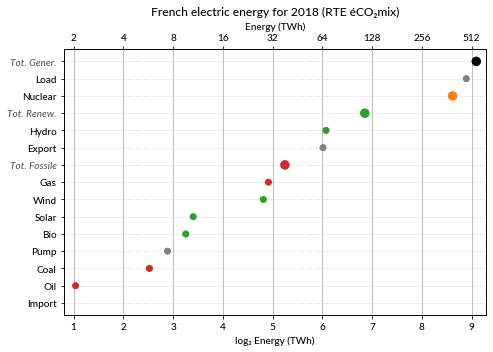

In [36]:
period = 2018

fig, ax = plt.subplots(1,1, figsize=(7,5))

# twin ax with shared scale
# cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
ax2 = ax.twiny()
ax.get_shared_x_axes().join(ax, ax2)

ax.scatter(
    log2(stats_int), stats_int.index,
    s = size_by_type, c = colors_by_type,
    marker='o')

ax.grid(axis='x', ls='-')
ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
ax.set_axisbelow(True) # grid below data points

ax.set(
    xlabel='log₂ Energy (TWh)',
    xlim=(0.8, 9.3),
    title=f'French electric energy for {period} (RTE éCO₂mix)'
)

ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
ax2.set_xlabel('Energy (TWh)')

fig.tight_layout()

# Italize ticklabels with "Tot..."
for t in ax.get_yticklabels():
    if t.get_text().startswith('Tot'):
        t.set_fontstyle('italic')
        t.set_color('#555555')

fig.savefig(f'Dotplot_Powersys_{period}_int_colored.png', dpi=300, bbox_inches='tight')

Note: setting the ticklabel style only works after calling `fig.tight_layout()`. Otherwise, `Text` objects are empty...

#### Multi way dot plot: many stats for a single period

showing max, avg and also quantiles with lines

Color and marker for max and avg stat:

In [37]:
smarkers = {
    'avg': 'o',
    'max': '^'}

scolors = {
    'avg': 'tab:blue',
    'max': 'tab:red'}

Highlight range values for which the off time is significant:

In [38]:
# Color highlight
gray = (0.7,)*3
rgray = (0.9, 0.75, 0.75) # reddish gray

def qcolor(stats):
    'color list for quantile range lines'
    return [gray if stats.off[t] < 0.01 else rgray for t in stats.index]

def qls(stats):
    'line style lists for quantile range lines'
    return ['-' if stats.off[t] < 0.01 else '--' for t in stats.index]

qls(stats)

['--', '-', '--', '--', '-', '--', '-', '-', '--', '-', '-', '-']

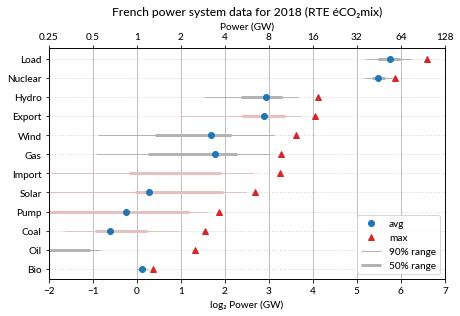

In [39]:
def dotplot_powersys(stats, period, suffix=''):
    """Cleveland dot plot for power system data of a single `period` (str)
    
    `stats` DataFrame should contain power system items as index
    and the following statistics as columns: max, avg, off, q05, q25, q75 and q95
    """
    fig, ax = plt.subplots(1,1, figsize=(6.5,4.5))

    # twin ax with shared scale
    # cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
    ax2 = ax.twiny()
    ax.get_shared_x_axes().join(ax, ax2)

    # Plot avg and max as dots
    for col in ['avg', 'max']:
        ax.plot(log2(stats[col]), stats.index, label=col,
                ls='', marker=smarkers[col], color=scolors[col])

    # Plot quantiles with lines
    ax.hlines(stats.index, log2(stats.q05), log2(stats.q95), label='90% range',
              lw=1, color=qcolor(stats), ls='-')
    ax.hlines(stats.index, log2(stats.q25), log2(stats.q75), label='50% range',
              lw=3, color=qcolor(stats), ls='-')


    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
    ax.set(
        xlabel='log₂ Power (GW)',
        xlim=(-2, 7),
        title=f'French power system data for {period} (RTE éCO₂mix)'
    )

    ax.legend(loc='lower right')

    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
    ax2.set_xlabel('Power (GW)')

    fig.tight_layout()
    fig.savefig(f'Dotplot_Powersys_{period}_{suffix}.png', dpi=300, bbox_inches='tight')

dotplot_powersys(stats.sort_values('max'), '2018', 'bymax')

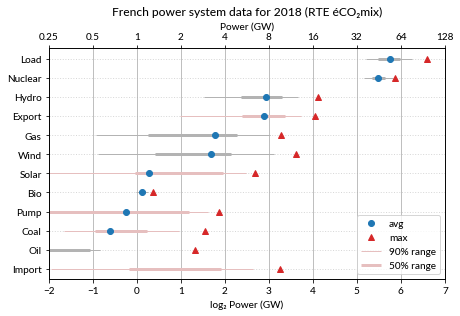

In [40]:
stats_byavg = stats.sort_values('avg')

dotplot_powersys(stats_byavg, '2018', 'byavg')

## Stats and plot for many years

### Stats for each available year

In [41]:
def preprocess(df):
    'preprocess RTE eCO2mix data before statistical aggregation'
    # translate names:
    df = df.rename(dict(zip(columns_FR, columns)), axis=1)

    # Sign flip for pumped hydro
    df.Pump *= -1
    
    # Split of imports and exports
    pos = lambda x:  x if x >= 0 else 0
    neg = lambda x: -x if x  < 0 else 0
    
    df['Import'] = df['Exchanges'].map(pos)
    df['Export'] = df['Exchanges'].map(neg)
    
    del df['Exchanges']
    
    # MW → GW
    df /= 1000
    
    return df

In [42]:
def power_stats(year):
    df = read_eCO2mix(f'data/eCO2mix_RTE_Annuel-Definitif_{year}.xls.xz', columns_FR)
    
    df = preprocess(df)
    
    # Mean and max
    stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})
    
    # Off time
    df_norm = df / df.max()
    df_zero = df_norm<0.01
    stat_off = df_zero.mean()
    stats['off'] = stat_off
    
    # Quantiles for nonzero values
    q_list = [0.05, 0.25, 0.75, 0.95]
    stats_q = df[~df_zero].quantile(q_list)
    
    for q in stats_q.index:
        q_name = f'q{100*q:02.0f}' # ex: 'q25'
        stats[q_name] = stats_q.loc[q]
    
    return stats

Compute the stats for each year (takes some seconds…)

In [43]:
stats_y = {y: power_stats(y) for y in range(2012, 2019)}

Concat the yearly stats (create a multi index)

In [44]:
stats_y = pd.concat(stats_y, axis=1)

**Sort**: by max of last year (2018)

In [45]:
stats_y.sort_values((2018,'max'), inplace=True)
stats_y

2012                                                             \
               avg      max       off       q05       q25       q75       q95   
Bio       0.664442    0.799  0.000000   0.56200   0.62400   0.71100   0.74700   
Oil       0.517325    5.926  0.000000   0.27600   0.29500   0.49200   1.09800   
Coal      1.986089    5.436  0.142304   0.35300   1.25300   3.28800   4.52765   
Pump      0.763865    3.376  0.420936   0.04800   0.36300   2.18600   2.92600   
Solar     0.430648    2.489  0.520719   0.06400   0.36100   1.36400   1.97005   
Import    0.146497    9.289  0.948372   0.26380   1.04550   4.33450   6.81300   
Gas       2.850610    8.625  0.000000   0.59100   0.82600   3.96000   7.50800   
Wind      1.696575    6.198  0.000683   0.32600   0.77475   2.32400   4.22850   
Export    5.400491   13.594  0.055499   1.61960   3.92100   7.43500  10.01240   
Hydro     7.213284   16.380  0.000000   3.33000   5.13900   9.06025  12.01930   
Nuclear  46.055824   60.811  0.000000  35.80600  39.45575  52.37925  58.93565   
Load     55.396962  102.098  0.000000  37.56035  45.90450  63.31200  80.30840   

              2013                    ...      2017                      \
               avg     max       off  ...       q25       q75       q95   
Bio       0.707971   0.835  0.000000  ...   1.01700   1.12900   1.22600   
Oil       0.453910   3.914  0.000000  ...   0.14300   0.56100   0.94300   
Coal      2.251811   6.265  0.159874  ...   0.72900   2.00200   2.51500   
Pump      0.821367   3.637  0.400970  ...   0.22600   2.14400   2.96100   
Solar     0.519008   2.950  0.521918  ...   0.90100   3.23500   4.65040   
Import    0.087988   4.930  0.938813  ...   1.25050   4.38475   6.61865   
Gas       2.282787   8.329  0.000000  ...   2.40100   7.00425   8.25700   
Wind      1.816477   6.531  0.000571  ...   1.22300   3.53900   7.57530   
Export    5.694872  13.198  0.067352  ...   3.80275   8.06500  10.87765   
Hydro     8.521735  16.805  0.000000  ...   4.11300   7.59150  10.68415   
Nuclear  46.058161  59.107  0.000000  ...  38.54675  47.59150  54.43410   
Load     56.185530  92.629  0.000000  ...  45.21900  63.06950  78.30445   

              2018                                                            
               avg     max       off       q05       q25       q75       q95  
Bio       1.089724   1.286  0.000000   0.98200   1.04200   1.13200   1.20200  
Oil       0.234531   2.507  0.000057   0.07300   0.08400   0.47600   0.55700  
Coal      0.656297   2.931  0.293265   0.31900   0.51800   1.18400   1.95200  
Pump      0.844762   3.651  0.350342   0.05000   0.18100   2.26100   3.08900  
Solar     1.208082   6.430  0.519692   0.17400   0.97200   3.87450   5.60930  
Import    0.109121   9.574  0.956849   0.25925   0.88825   3.78700   6.22575  
Gas       3.446567   9.700  0.000000   0.52300   1.18800   4.85400   8.10805  
Wind      3.211288  12.287  0.000742   0.54430   1.33800   4.38300   8.71700  
Export    7.383905  16.577  0.047432   1.97740   5.26000  10.32900  13.22200  
Hydro     7.695196  17.434  0.000000   2.89700   5.18775   9.90925  12.66715  
Nuclear  44.861127  58.640  0.000000  35.73270  40.44075  49.87925  56.46905  
Load     54.283220  96.272  0.000000  36.98195  44.92975  63.06900  75.99780  

[12 rows x 49 columns]

### Multi year plots

#### Off times over the years

TO BE DONE

#### Multi year dot plot

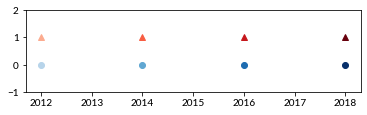

In [46]:
def scolor(year, years, stat, am=0.3, aM=1.0):
    """color for a symbol of a given year, for a given stat (avg or max)
    
    Color is taken by evaluating a colormap linearly on years,
    between lower value am and upper value aM.
    """
    ym = min(years)
    yM = max(years)
    
    if yM>ym:
        a = (year - ym)/(yM-ym) # in [0,1]
        a = am + a*(aM-am) # in [am, aM]
    else:
        a = 0.7
    if stat == 'avg':
        color = cm.Blues(a)
    elif stat == 'max':
        color = cm.Reds(a)
    return color

# Demo
years = [2012, 2014, 2016, 2018]
plt.figure(figsize=(6,1.5))
plt.ylim(-1,2)
for y in years:
    plt.plot(y, 0, 'o', color=scolor(y, years, 'avg'))
    plt.plot(y, 1, '^', color=scolor(y, years, 'max'))

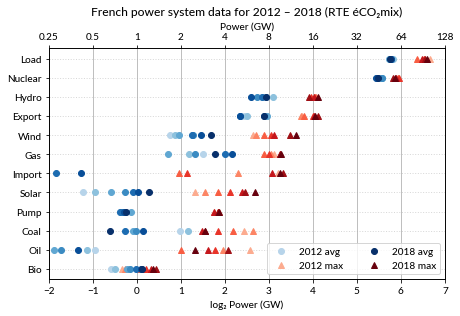

In [48]:
def dotplot_powersys_multi(stats_y, years, am=0.3, aM=1.0 ):
    """Cleveland dot plot for power system data over multiple `years` (list)
    
    `stats` DataFrame should contain power system items as index
    and the following statistics as columns: max, avg
    """
    fig, ax = plt.subplots(1,1, figsize=(6.5,4.5))
    
    # twin ax with shared scale
    # cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
    ax2 = ax.twiny()
    ax.get_shared_x_axes().join(ax, ax2)

    # Plot avg and max as dots
    for year in years:
        for s in ['avg', 'max']:
            col = (year, s)
            
            # label only first and last year:
            label = f'{year} {s}'  if year == years[0] or year == years[-1] else ''
            
            ax.plot(log2(stats_y[col]), stats_y.index, label=label,
                    ls='', marker=smarkers[s],
                    color=scolor(year, years, s, am, aM))

    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
    period = f'{years[0]} – {years[-1]}' if years[0] !=  years[-1] else f'{years[0]}'
    ax.set(
        xlabel='log₂ Power (GW)',
        xlim=(-2, 7),
        title=f'French power system data for {period} (RTE éCO₂mix)'
    )
    ax.locator_params('x', nbins=10)
    
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
    ax2.set_xlabel('Power (GW)')
    
    ncol = 2 if years[0] !=  years[-1] else 1
    ax.legend(loc='lower right', ncol=ncol)

    fig.tight_layout() # rect=(0,0.1,1,1) for when the legend is on the figure
    years_txt = '20' + '-'.join(str(y)[2:] for y in years)
    fig.savefig(f'Dotplot_Powersys_{years_txt}.png', dpi=300, bbox_inches='tight')

dotplot_powersys_multi(stats_y, range(2012, 2019))

Plot only first and last year:

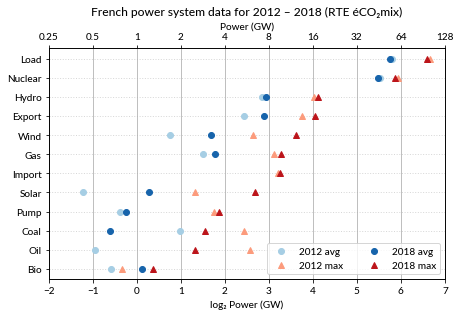

In [207]:
dotplot_powersys_multi(stats_y, [2012, 2018], am=0.35, aM=0.8)

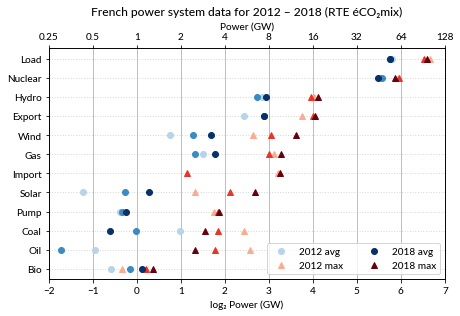

In [208]:
dotplot_powersys_multi(stats_y, [2012, 2015, 2018])

2012, 2015, 2018, sorted by 2018 avg

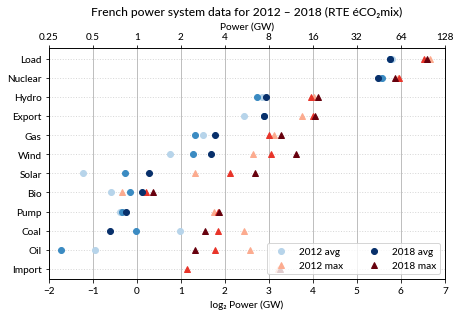

In [49]:
dotplot_powersys_multi(stats_y.sort_values((2018,'avg')), [2012, 2015, 2018])

Generate the individual plot for each year

In [202]:
stats_y[2012]

,avg,max,off,q05,q25,q75,q95
Bio,0.664442,0.799,0.000000,0.56200,0.62400,0.71100,0.74700
Oil,0.517325,5.926,0.000000,0.27600,0.29500,0.49200,1.09800
Coal,1.986089,5.436,0.142304,0.35300,1.25300,3.28800,4.52765
Pump,0.763865,3.376,0.420936,0.04800,0.36300,2.18600,2.92600
Solar,0.430648,2.489,0.520719,0.06400,0.36100,1.36400,1.97005
Import,0.146497,9.289,0.948372,0.26380,1.04550,4.33450,6.81300
Gas,2.850610,8.625,0.000000,0.59100,0.82600,3.96000,7.50800
Wind,1.696575,6.198,0.000683,0.32600,0.77475,2.32400,4.22850
Export,5.400491,13.594,0.055499,1.61960,3.92100,7.43500,10.01240
Hydro,7.213284,16.380,0.000000,3.33000,5.13900,9.06025,12.01930


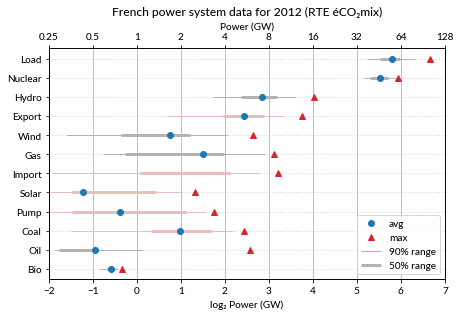

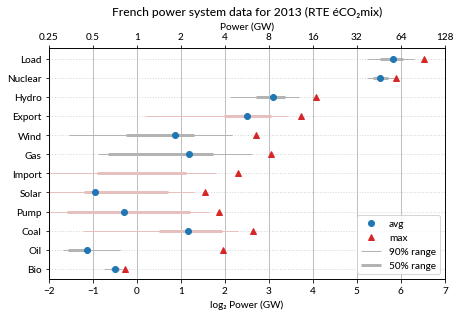

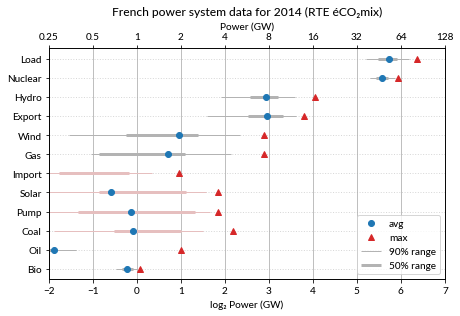

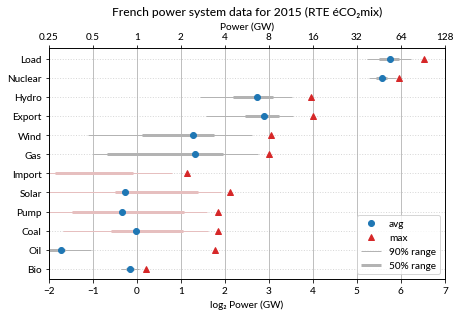

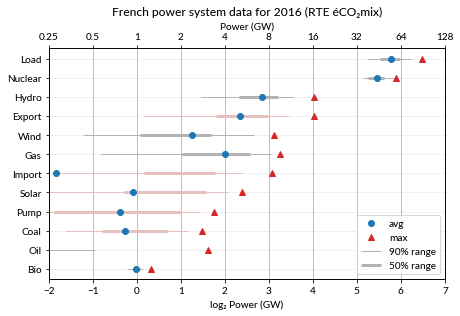

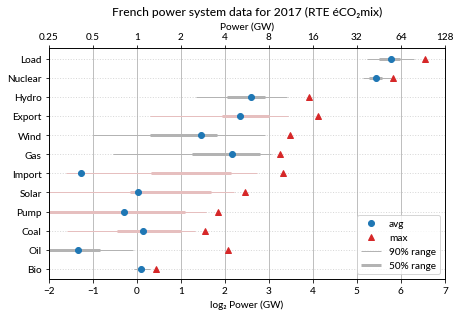

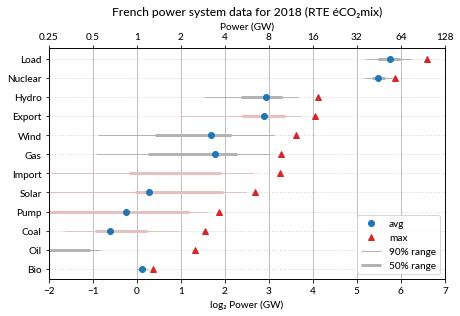

In [204]:
for year in range(2012, 2019):
    dotplot_powersys(stats_y[year], year, 'bymax2018')

## Plot with Altair

https://altair-viz.github.io/

In [50]:
import altair as alt

reshaping data to from wide to [long-form](https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data) with `DataFrame.melt` or `DataFrame.stack`:

Option 1: stacking only the years, keeping statistics type as columns

In [ ]:
stats_yl1.drop(['q05', 'q05'])

In [91]:
stats_yl1.avg

0      0.664442
1      0.707971
2      0.857310
3      0.903689
4      0.991731
        ...    
79    52.779499
80    54.012878
81    54.681288
82    54.685462
83    54.283220
Name: avg, Length: 84, dtype: float64

In [93]:
stats_yl1 = stats_y.stack(0).reset_index()
stats_yl1.rename(columns={'level_0':'type', 'level_1':'year'}, inplace=True)

# add log2 transform for avg and max
stats_yl1['log_avg'] = log2(stats_yl1.avg)
stats_yl1['log_max'] = log2(stats_yl1['max'])

# add capacity factor
stats_yl1['cf'] = stats_yl1.avg/stats_yl1['max']

stats_yl1

,type,year,avg,max,off,q05,q25,q75,q95,log_avg,log_max,cf
0,Bio,2012,0.664442,0.799,0.0,0.56200,0.62400,0.71100,0.74700,-0.589785,-0.323733,0.831592
1,Bio,2013,0.707971,0.835,0.0,0.59700,0.66800,0.75300,0.79800,-0.498237,-0.260152,0.847870
2,Bio,2014,0.857310,1.049,0.0,0.71900,0.78800,0.94100,1.00100,-0.222112,0.069015,0.817264
3,Bio,2015,0.903689,1.161,0.0,0.77500,0.85100,0.95500,1.03500,-0.146102,0.215368,0.778371
4,Bio,2016,0.991731,1.261,0.0,0.86300,0.93700,1.04900,1.10900,-0.011979,0.334568,0.786464
...,...,...,...,...,...,...,...,...,...,...,...,...
79,Load,2014,52.779499,82.607,0.0,36.91475,44.39675,60.11975,72.80945,5.721906,6.368192,0.638923
80,Load,2015,54.012878,91.934,0.0,37.29870,45.23975,61.74975,75.33115,5.755232,6.522527,0.587518
81,Load,2016,54.681288,88.731,0.0,37.37735,45.93700,63.29600,74.62045,5.772975,6.471366,0.616259
82,Load,2017,54.685462,94.236,0.0,37.43085,45.21900,63.06950,78.30445,5.773085,6.558206,0.580303


Option 2: stack both the year and the statistics type

In [83]:
stats_yl2 = stats_y.reset_index().melt('index', var_name=['year', 'stat'])
stats_yl2.rename(columns={'index':'type'}, inplace=True)

# log2 transform
stats_yl2['log2'] = np.log2(stats_yl2.value)
stats_yl2

/home/pierre/Programmes/bin/miniconda3.7/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,type,year,stat,value,log2
0,Bio,2012,avg,0.664442,-0.589785
1,Oil,2012,avg,0.517325,-0.950856
2,Coal,2012,avg,1.986089,0.989930
3,Pump,2012,avg,0.763865,-0.388610
4,Solar,2012,avg,0.430648,-1.215420
...,...,...,...,...,...
583,Wind,2018,q95,8.717000,3.123832
584,Export,2018,q95,13.222000,3.724869
585,Hydro,2018,q95,12.667150,3.663020
586,Nuclear,2018,q95,56.469050,5.819388


Rows with avg or max stat:

In [84]:
avg_max = (stats_yl2.stat == 'avg') | (stats_yl2.stat == 'max')
avg_max.sum()

168

In [85]:
stats_yl = stats_yl2[avg_max]

short alias for the year column:

In [86]:
y = stats_yl.year

Use the same sorting as `stats_y`:

In [87]:
sorted_types = stats_y.index.values
sorted_types = list(sorted_types)
sorted_types.reverse()
print(sorted_types)

['Load', 'Nuclear', 'Hydro', 'Export', 'Wind', 'Gas', 'Import', 'Solar', 'Pump', 'Coal', 'Oil', 'Bio']


### Plot a single year

TODO: make some config persistent in the theme

WOULD BE NICE TO HAVE: add a drop down menu to sort by avg or max?

In [39]:
alt.themes.get()()

{'config': {'view': {'width': 400, 'height': 300}, 'mark': {'tooltip': None}}}

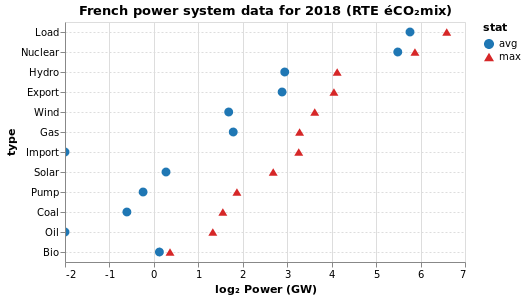

In [94]:
shape_scale = alt.Scale(domain=['avg', 'max'], range=['circle', 'triangle-up'])

tab_blue = '#1f77b4' # ( 31, 119, 180)
tab_red = '#d62728' # (214,  39,  40)
color_scale = alt.Scale(domain=['avg', 'max'], range=[tab_blue, tab_red])

alt.Chart(stats_yl[y==2018]).mark_point(filled=True, size=80, opacity=1).encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color=alt.Color('stat',
        scale=color_scale
    ),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).properties(
    title='French power system data for 2018 (RTE éCO₂mix)'
).configure_axisY(
    grid=True,
    gridDash=(2,2)
).interactive()

Same plot using the partially stacked data (option 1)

* advantage: better tooltip, since we can show all the interesting stats
* drawback: more verbose, because requires layering two charts
  * but no more more need to fiddle with color and shape scale

TODO: add legend entry

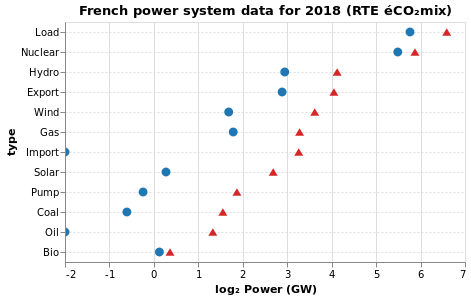

In [100]:
tab_blue = '#1f77b4' # ( 31, 119, 180)
tab_red = '#d62728' # (214,  39,  40)

base = alt.Chart(
    stats_yl1[stats_yl1.year==2018]
).mark_point(
    filled=True, size=80, opacity=1
).encode(
    y=alt.Y('type', sort=sorted_types),
    tooltip=['year', 'avg', 'max', 'cf']
)

avg_chart = base.encode(
    x=alt.X('log_avg', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    shape=alt.value('circle'),
    color=alt.value(tab_blue)
)

max_chart = base.encode(
    x=alt.X('log_max', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    shape=alt.value('triangle-up'),
    color=alt.value(tab_red)
)

chart = avg_chart + max_chart
chart.properties(
    title='French power system data for 2018 (RTE éCO₂mix)'
).configure_axisY(
    grid=True,
    gridDash=(2,2)
).interactive()

### Plot all years

a bit confusing when the coloring function of years is not added

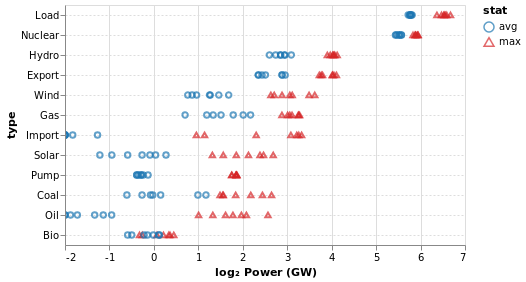

In [41]:
alt.Chart(stats_yl).mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color=alt.Color('stat',
        scale=color_scale
    ),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    #size='year:O', # interesting, but looks messy
    tooltip=['year', 'value']
).configure_axisY(
    grid=True,
    gridDash=(2,2)
).interactive()

With color scale for years:

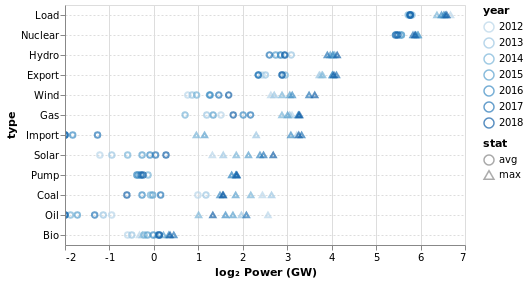

In [42]:
alt.Chart(stats_yl).mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color='year:O',
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).configure_axisY(
    grid=True,
    gridDash=(2,2)
).interactive()

### All years - with interactive selection


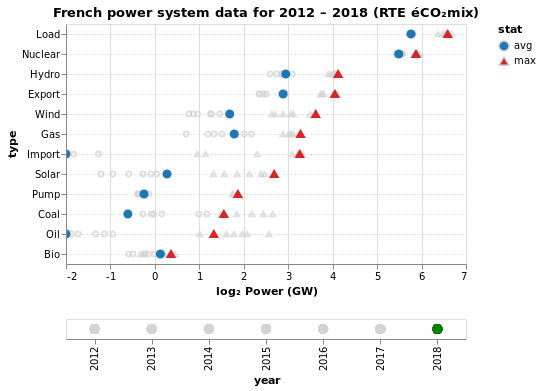

In [43]:
selector = alt.selection_single(
    fields=['year'],
    empty='none',
    on='mouseover',
    nearest=True,
    init=alt.SelectionInitMapping(year=2018)
)

base = alt.Chart(stats_yl).properties(
    width=400,
).add_selection(selector)

# The Dot plot
values  = base.mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    # Make color, size, etc... interactive
    fill=alt.condition(
        selector,
        alt.Color('stat:N',scale=color_scale),
        alt.value('lightgray')
    ),
    stroke=alt.condition(
        selector,
        alt.Color('stat:N',scale=color_scale),
        alt.value('lightgray')
    ),
    fillOpacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0)),
    opacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0.7)),
    size=alt.condition(selector,
                       alt.value(50),
                       alt.value(25)),
    tooltip=['year', 'value']
).properties(
    title='French power system data for 2012 – 2018 (RTE éCO₂mix)'
).interactive()

# Year selector
years = base.mark_point(filled=True, size=100).encode(
    x='year:O',
    color=alt.condition(selector,
                        alt.value('green'),
                        alt.value('lightgray')),
)

chart = values & years
chart.configure_axisY(
    grid=True,
    gridDash=(2,2)
)

A variant using layered charts, so that the selected points are drawn **over** the others.

Only minor issue is the double legend. May relate to Vega-Lite issue [#3797](https://github.com/vega/vega-lite/issues/3797)

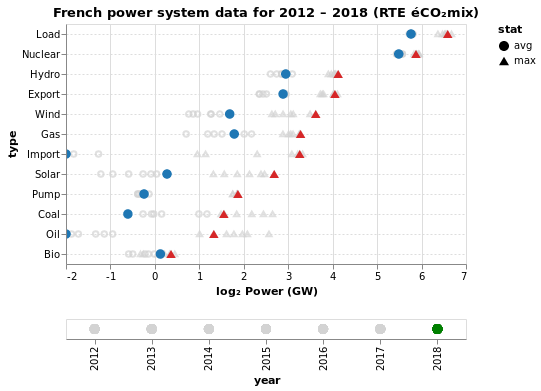

In [51]:
selector = alt.selection_single(
    fields=['year'],
    empty='none',
    on='mouseover',
    nearest=True,
    init=alt.SelectionInitMapping(year=2018)
)

base = alt.Chart(stats_yl).properties(
    width=400,
)

# The Dot plot
values = base.encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
)

# small light gray points for unselected values
values_gray = values.mark_point().encode(
    color=alt.value('lightgray'),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale,
        legend=None
    )
)

values_highlight = values.encode(
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    color=alt.Color('stat', scale=color_scale, legend=None),
    tooltip=['year', 'value'],
    # show only when selected
    opacity=alt.condition(selector, alt.value(1), alt.value(0))
).mark_point(filled=True, opacity=1, size=90
).add_selection(selector)

# Superimposition:
values = (values_gray + values_highlight).properties(
    title='French power system data for 2012 – 2018 (RTE éCO₂mix)'
).interactive()

# Year selector
years = base.mark_point(filled=True, size=100).encode(
    x='year:O',
    color=alt.condition(selector,
                        alt.value('green'),
                        alt.value('lightgray')),
).add_selection(selector)

# Vertical concat:
chart = values & years
chart = chart.configure_axisY(
    grid=True,
    gridDash=(2,2)
)
chart

In [52]:
chart.save('Dotplot_Powersys_interactive.html')
chart.save('Dotplot_Powersys_interactive.json')